# Topic/User Analysis

## Load Data

In [1]:
from math import log2
from collections import Counter
import pandas as pd
import numpy as np

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from utility import (
    get_user_frequent_topic,
    get_user_dominant_topic,
    topic_entropy,
    Log2,
    cramers_v,
    rank_biserial_from_u,
    cliffs_delta,
    compare_groups,
    plot_entropy_distribution,
    plot_effective_topic_count,
)


In [29]:

chosen_dataset = "cop26_tweets_en"
chosen_dataset = "covid_tweets_en"
chosen_dataset = "ukraine_tweets_en"
ur_df = pd.read_parquet("./../../data/raw/" + chosen_dataset + ".parquet")
# change type of 'author_id' to string
# to ensure character-by-character comparison
ur_df["author_id"] = ur_df["author_id"].astype(str)
print(ur_df.columns)

Index(['id', 'author_id', 'created_at', 'lang', 'in_reply_to_user_id',
       'conversation_id', 'text', 'reply_settings', 'possibly_sensitive',
       'retweeted_id', 'quoted_id', 'replied_id', 'url', 'expanded_url',
       'mention_name', 'hashtags', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'username', 'individual_or_org',
       'category'],
      dtype='object')


In [30]:

doc_info = pd.read_csv(
    "./../../data/processed/document_info_" + chosen_dataset + ".csv"
)[["Document", "Topic", "Representative_document", "Name"]]
doc_info.Topic = doc_info.Topic.astype(int)
# embeddings = np.load('./../../data/processed/'+chosen_dataset+'.parquet.npy')
print(doc_info.columns)

Index(['Document', 'Topic', 'Representative_document', 'Name'], dtype='object')


In [31]:
usr_info = pd.read_csv("./../../data/raw/political_stance_merged.csv")
print(usr_info.columns)  # merge on 'username'

Index(['username', 'political_leaning', 'reliability'], dtype='object')


## Merge dataset
Merge Topic data with Tweets so that retweets are included.

In [32]:
# merge ur_df with doc_info on 'text'
merged_df = ur_df.merge(doc_info, left_on="text", right_on="Document", how="left")
assert len(merged_df) == len(ur_df), (
    "differing length before and after merge, duplicates in right"
)


## Assign Topic to Users
Many strategies were employed to assign topics to users, resulting in different retention percentages and interpretations.
- frequency: easy interpretation, higher retention.
- entropy: clearer interpretation, lower retention.

Both strategies return the most common topic.
In each case noise topic is excluded from computation.
If no topic is found that meets the requirements, no topic is assigned.


### Frequency to assign Topics to Users
Group topics by users, and assign the dominant topic using a frequency threshold.

The most frequent topic that exceeds exceeds the threshold, it is assigned to a user as the dominant one.
On ties, the topic with lowest id is assigned.

**TLDR: Frequency = Raw numbers**

### Entropy to assign Topics to Users

If we want to assign topics unambigously to all users, we can use entropy to assign them.

We assign a topic only if entropy of the user's topic distribution is low, i.e., user is focused.
To do so, we compute entropy of users' topic distributions, excluding noise (topic -1).

Then, we prevent the assignment of topics in the presence of ties.

**TLDR: Entropy = User Focus**
| Entropy | Interpretation                                             |
| ------- | ---------------------------------------------------------- |
| 0       | All tweets in one topic (perfect focus)                    |
| \~1     | Tweets mostly in 2 topics                                  |
| \~2     | Tweets across 4 topics fairly evenly                       |
| \~3     | Tweets across \~8 topics                                   |
| \~4     | Tweets across \~16 topics                                  |
| ...     | ... (upper limit is $\log_2(N)$, where $N$ = total topics) |


#### User Retention
Different strategies lead to different assignments to users.
Frequency strategy assigns topics to less users with higher frequency, whereas lower frequencies lead to more deterministic assignments.
Entropy is able to assign more users with a dominant topic with low thresholds, but still 5% of users are left with unassigned topics with a maximum entropy of 3 (8 or more prevalent topics).

Arguably, entropy is a sounder strategy.

In [33]:
user_topics = merged_df.groupby("author_id")["Topic"].apply(list)

# Compute entropy of topic distributions among users.
user_topic_entropy = user_topics.apply(lambda topics: topic_entropy(topics))

# try with log₂(2)=1 max entropy
user_dominant_topic_1 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(2))
)

# try with log₂(3) max entropy
user_dominant_topic_1_5 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(3))
)

# Try with log₂(4)=2 max entropy
user_dominant_topic_2 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(4))
)

# Try with log₂(6) max entropy
user_dominant_topic_2_3 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(5))
)

# Try with log₂(5) max entropy
user_dominant_topic_2_5 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(6))
)

# Try with log₂(8)=3 max entropy
user_dominant_topic_3 = user_topics.apply(
    lambda topics: get_user_dominant_topic(topics, max_entropy=log2(8))
)

user_frequent_topic_60 = user_topics.apply(
    lambda topics: get_user_frequent_topic(topics, threshold=0.6)
)
user_frequent_topic_50 = user_topics.apply(
    lambda topics: get_user_frequent_topic(topics, threshold=0.5)
)
user_frequent_topic_30 = user_topics.apply(
    lambda topics: get_user_frequent_topic(topics, threshold=0.3)
)
user_frequent_topic_20 = user_topics.apply(
    lambda topics: get_user_frequent_topic(topics, threshold=0.2)
)
user_frequent_topic_10 = user_topics.apply(
    lambda topics: get_user_frequent_topic(topics, threshold=0.1)
)

# Combine into a DataFrame for comparison
result = pd.DataFrame(
    {
        "topic_entropy": user_topic_entropy,
        "effective_topic_number": np.exp2(user_topic_entropy),
        "dominant_topic_2": user_dominant_topic_1,
        "dominant_topic_3": user_dominant_topic_1_5,
        "dominant_topic_4": user_dominant_topic_2,
        "dominant_topic_5": user_dominant_topic_2_3,
        "dominant_topic_6": user_dominant_topic_2_5,
        "dominant_topic_8": user_dominant_topic_3,
        "frequent_topic_60": user_frequent_topic_60,
        "frequent_topic_50": user_frequent_topic_50,
        "frequent_topic_30": user_frequent_topic_30,
        "frequent_topic_20": user_frequent_topic_20,
        "frequent_topic_10": user_frequent_topic_10,
    }
)
# change index type of 'result' to string
# to ensure character by character comparison
result.index = result.index.astype(str)

print(
    f"User retention with H<{Log2(2)=} max entropy:\t{100 - float(round(result.dominant_topic_2.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with H<{Log2(3)=} max entropy:\t{100 - float(round(result.dominant_topic_3.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with H<{Log2(4)=} max entropy:\t{100 - float(round(result.dominant_topic_4.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with H<{Log2(5)=} max entropy:\t{100 - float(round(result.dominant_topic_5.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with H<{Log2(6)=} max entropy:\t{100 - float(round(result.dominant_topic_6.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with H<{Log2(8)=} max entropy:\t{100 - float(round(result.dominant_topic_8.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with frequency ≥{60}%:\t{100 - float(round(result.frequent_topic_60.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with frequency ≥{50}%:\t{100 - float(round(result.frequent_topic_50.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with frequency ≥{30}%:\t{100 - float(round(result.frequent_topic_30.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with frequency ≥{20}%:\t{100 - float(round(result.frequent_topic_20.isna().sum() / len(result), 2) * 100)}%"
)
print(
    f"User retention with frequency ≥{10}%:\t{100 - float(round(result.frequent_topic_10.isna().sum() / len(result), 2) * 100)}%"
)
result

User retention with H<Log2(2)=1.0 max entropy:	2.0%
User retention with H<Log2(3)=1.58 max entropy:	3.0%
User retention with H<Log2(4)=2.0 max entropy:	5.0%
User retention with H<Log2(5)=2.32 max entropy:	9.0%
User retention with H<Log2(6)=2.58 max entropy:	11.0%
User retention with H<Log2(8)=3.0 max entropy:	20.0%
User retention with frequency ≥60%:	4.0%
User retention with frequency ≥50%:	5.0%
User retention with frequency ≥30%:	11.0%
User retention with frequency ≥20%:	23.0%
User retention with frequency ≥10%:	65.0%


,topic_entropy,effective_topic_number,dominant_topic_2,dominant_topic_3,dominant_topic_4,dominant_topic_5,dominant_topic_6,dominant_topic_8,frequent_topic_60,frequent_topic_50,frequent_topic_30,frequent_topic_20,frequent_topic_10
author_id,,,,,,,,,,,,,
1001775960763588608,2.911182,7.522343,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,2.0
1003662615661436929,3.348971,10.189214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1003895325025865730,2.687363,6.441350,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,5.0
1010384732759252997,2.902215,7.475731,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,NaN,74.0,74.0
1015683182060945408,4.210926,18.518898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
988433413303603201,2.561633,5.903754,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,2.0,2.0
988955288,2.884644,7.385238,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,3.0
991613369751867392,2.489363,5.615300,NaN,NaN,NaN,NaN,8.0,8.0,NaN,NaN,NaN,8.0,8.0


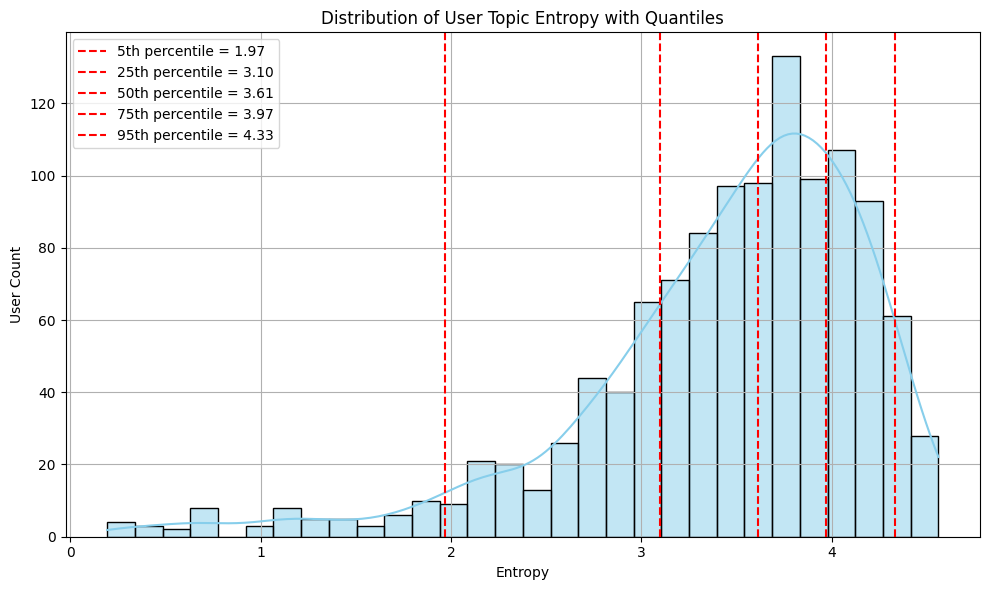

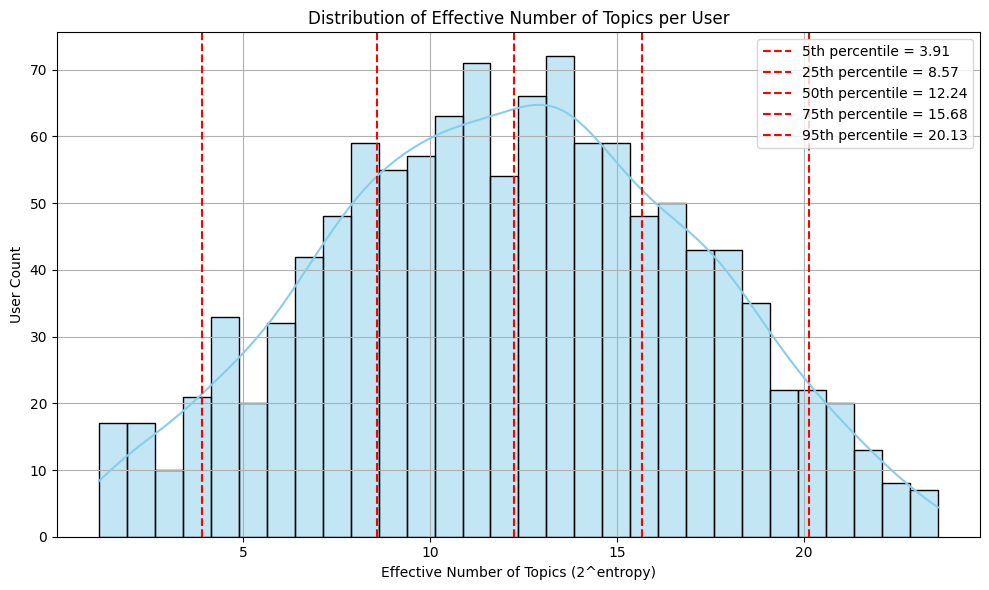

In [34]:

plot_entropy_distribution(user_topic_entropy)



plot_effective_topic_count(user_topic_entropy)

In [35]:
# Examples of users with focus on 8 or more topics
for r in user_topics.iloc[np.where(user_topic_entropy > 3)]:
    r = np.array(r)
    if len(r[np.where(r != -1)]) > 0:
        print(Counter(r[np.where(r != -1)].tolist()))

Counter({7: 17, 2: 7, 50: 7, 10: 5, 55: 4, 1: 4, 32: 4, 33: 4, 4: 3, 16: 3, 3: 3, 9: 3, 60: 3, 79: 3, 0: 3, 152: 2, 34: 2, 36: 2, 69: 2, 25: 2, 13: 2, 8: 1, 39: 1, 132: 1, 30: 1, 113: 1, 163: 1, 15: 1, 126: 1, 14: 1, 31: 1, 11: 1, 116: 1, 146: 1, 127: 1, 95: 1, 87: 1, 100: 1, 161: 1, 19: 1, 76: 1})
Counter({3: 56, 24: 35, 0: 35, 2: 35, 22: 31, 4: 18, 43: 18, 6: 17, 1: 16, 17: 15, 21: 14, 5: 14, 10: 13, 29: 13, 8: 12, 18: 11, 110: 11, 64: 10, 95: 9, 62: 9, 96: 9, 54: 9, 12: 9, 41: 9, 28: 8, 15: 8, 76: 8, 14: 8, 65: 7, 7: 7, 70: 7, 49: 7, 38: 6, 60: 6, 35: 6, 13: 6, 32: 6, 92: 6, 19: 6, 59: 6, 16: 6, 34: 5, 40: 5, 47: 5, 25: 5, 31: 4, 23: 4, 78: 4, 155: 4, 89: 4, 52: 4, 139: 4, 142: 4, 33: 4, 68: 4, 114: 4, 48: 4, 9: 4, 20: 3, 90: 3, 39: 3, 11: 3, 88: 3, 58: 3, 148: 3, 140: 3, 101: 3, 86: 3, 81: 3, 61: 3, 129: 3, 53: 2, 42: 2, 56: 2, 112: 2, 108: 2, 84: 2, 106: 2, 151: 2, 131: 2, 99: 2, 123: 2, 91: 2, 126: 2, 71: 2, 144: 2, 80: 2, 146: 2, 30: 2, 63: 2, 121: 1, 57: 1, 113: 1, 67: 1, 137: 

Topics are floats because some topics are NaN.

Will eliminate NaN and convert dtype to int when final results will be added

## Combine with user metadata
Load metadata and explore results

In [36]:
# `user_metadata` is a DataFrame with columns like:
# 'id', 'individual_or_org', 'category'
if chosen_dataset == "cop26_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_cop26.csv")
elif chosen_dataset == "covid_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_covid.csv")
elif chosen_dataset == "ukraine_tweets_en":
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_ru_ukr.csv")
# print(f"{result.index.dtype}")
user_metadata.id = user_metadata.id.astype(str)
print(f"{user_metadata['id'].dtype=}")
user_metadata.columns

user_metadata['id'].dtype=dtype('O')


Index(['id', 'username', 'individual_or_org', 'category', 'num_of_rt',
       'num_original_tweets', 'followers_count', 'num_of_retweeters'],
      dtype='object')

In [37]:
# Merge with user-topic assignments from previous step
combined_df = user_metadata.merge(result, left_on="id", right_on="author_id")
# Merge with information on users: political_leaning and reliability
combined_df = combined_df.merge(usr_info, on="username", how="left")

Use crosstabs and grouped bar plots to explore distributions.

In [38]:
# Crosstab example
pd.crosstab(
    combined_df["individual_or_org"],
    combined_df["dominant_topic_3"],
    normalize="index",
)

dominant_topic_3,0.0,1.0,3.0,6.0,9.0,10.0,11.0,19.0,20.0,26.0,...,44.0,51.0,52.0,66.0,85.0,103.0,111.0,120.0,136.0,152.0
individual_or_org,,,,,,,,,,,,,,,,,,,,,
Individual,0.000000,0.190476,0.142857,0.047619,0.047619,0.000000,0.000000,0.047619,0.047619,0.095238,...,0.142857,0.047619,0.000000,0.000000,0.047619,0.047619,0.047619,0.000000,0.000000,0.000000
Organization,0.352941,0.058824,0.000000,0.000000,0.000000,0.058824,0.117647,0.000000,0.000000,0.058824,...,0.058824,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.058824,0.058824,0.058824


In [39]:
pd.crosstab(
    combined_df["category"], combined_df["dominant_topic_3"], normalize="index"
)

dominant_topic_3,0.0,1.0,3.0,6.0,9.0,10.0,11.0,19.0,20.0,26.0,...,44.0,51.0,52.0,66.0,85.0,103.0,111.0,120.0,136.0,152.0
category,,,,,,,,,,,,,,,,,,,,,
Activist,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.333333,0.000000,0.0,0.000000
International Organization / NGO,0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,...,0.111111,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111
Media,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000
Other,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.000000
Politics,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Private Individual,0.000000,0.083333,0.083333,0.083333,0.083333,0.000000,0.000000,0.083333,0.000000,0.083333,...,0.166667,0.083333,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,0.000000


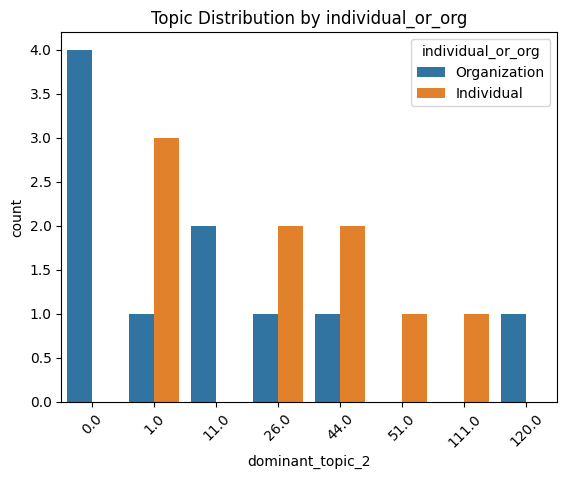

In [40]:
sns.countplot(data=combined_df, x="dominant_topic_2", hue="individual_or_org")
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

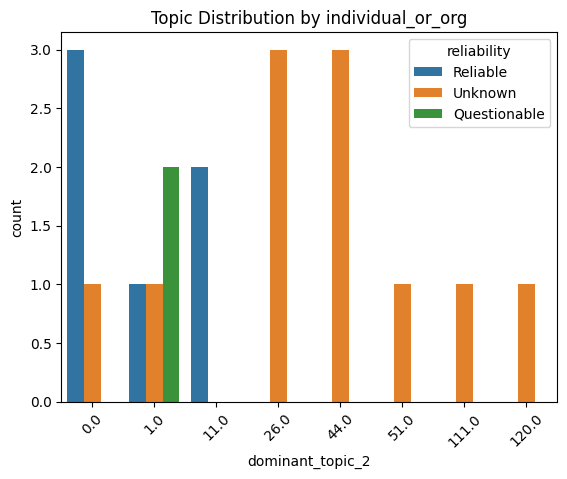

In [41]:
sns.countplot(data=combined_df, x="dominant_topic_2", hue="reliability")
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

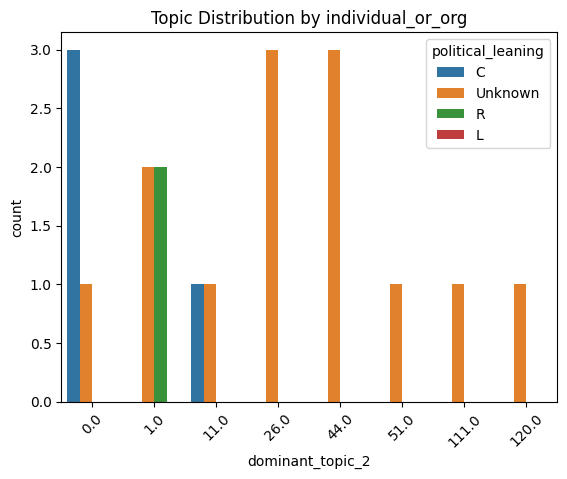

In [42]:
sns.countplot(data=combined_df, x="dominant_topic_2", hue="political_leaning")
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

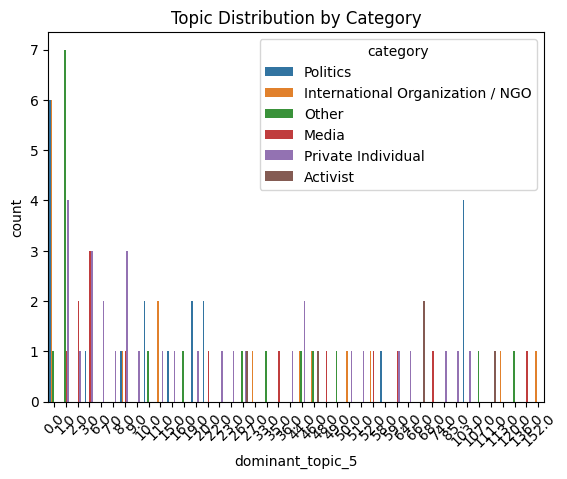

In [43]:
sns.countplot(data=combined_df, x="dominant_topic_5", hue="category")
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()


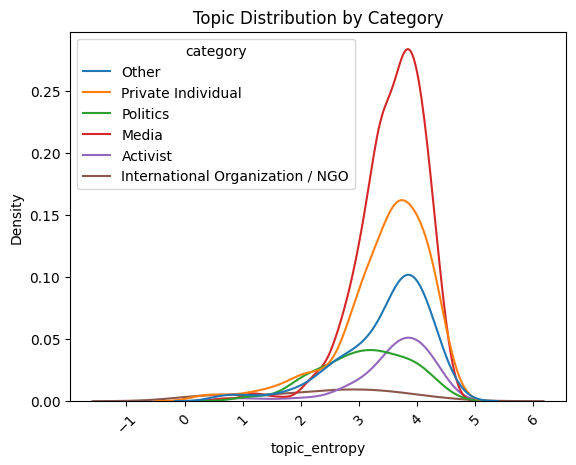

In [44]:
sns.kdeplot(data=combined_df, x="topic_entropy", hue="category")
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

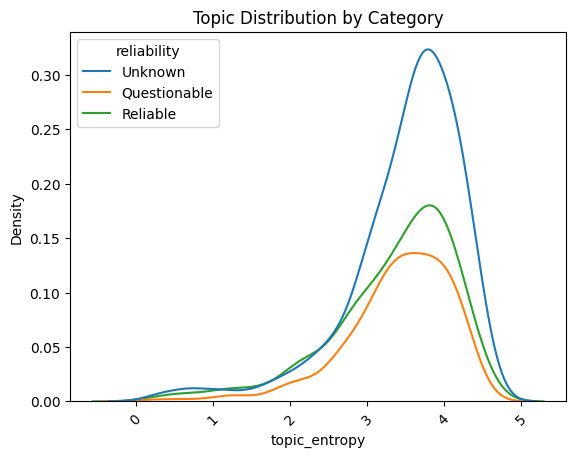

In [45]:
sns.kdeplot(data=combined_df, x="topic_entropy", hue="reliability")
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

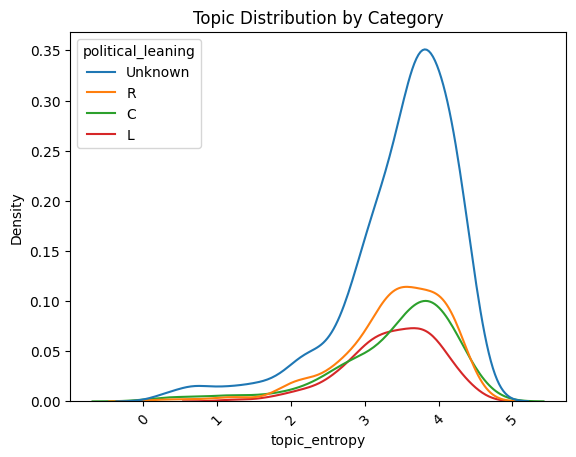

In [46]:
sns.kdeplot(data=combined_df, x="topic_entropy", hue="political_leaning")
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

## Statistical Test for Association
### Chi²
Use Chi² for categorical association, and Cramer's V
Low p-value (e.g. < 0.05) → strong evidence that topic assignment and political leaning are not independent.
### Cramer's V 
Interpretation of effect size

|Effect size (ES) | Interpretation|
| --------- | --------- |
|ES ≤ 0.2	| The result is weak. Although the result is statistically significant, the fields are only weakly associated.|
|0.2 < ES ≤ 0.6	| The result is moderate. The fields are moderately associated.|
|ES > 0.6	| The result is strong. The fields are strongly associated.|


In [47]:
for variable in ["reliability", "political_leaning", "individual_or_org", "category"]:
    contingency_table = pd.crosstab(
        combined_df[variable], combined_df["dominant_topic_8"]
    )
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\033[33m{variable.upper()}\033[0m")
    effect_size = cramers_v(contingency_table)
    print(f"Chi-square statistic: {chi2}, p-value: {p}")
    print(f"Cramer's V: {effect_size}")
    print(
        f"\033[33m{variable.title()}\033[0m and dominant topic are \033[31m{'not ' * (p > 0.05)}significant\033[0m and \033[31m{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033[0m."
    )
    print()

RELIABILITY
Chi-square statistic: 126.14318787715756, p-value: 0.17054548541736822
Cramer's V: 0.5191692654936756
Reliability and dominant topic are not significant and moderately associated.

POLITICAL_LEANING
Chi-square statistic: 218.81380633503397, p-value: 0.005099097959536336
Cramer's V: 0.5583015124686971
Political_Leaning and dominant topic are significant and moderately associated.

INDIVIDUAL_OR_ORG
Chi-square statistic: 60.91571648902475, p-value: 0.30357115616992714
Cramer's V: 0.514636708034541
Individual_Or_Org and dominant topic are not significant and moderately associated.

CATEGORY
Chi-square statistic: 385.0773721802514, p-value: 3.047524435333933e-05
Cramer's V: 0.5736950053193944
Category and dominant topic are significant and moderately associated.



/tmp/ipykernel_27860/479742155.py:11: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033."
/tmp/ipykernel_27860/479742155.py:11: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 0.6 else 'strong'}ly associated\033."
/tmp/ipykernel_27860/479742155.py:11: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  f"\033{variable.title()}\033 and dominant topic are \033{'not ' * (p > 0.05)}significant\033 and \033{'weak' if effect_size <= 0.2 else 'moderate' if effect_size <= 

## Tests for difference in distribution

### Mann-Whitney U test
>- Null hypothesis: The probability that a randomly chosen observation from group A is greater than one from group B is equal to the probability it is less.
>- Equivalently, the two distributions are equal in location and shape (assuming continuous data with no ties).
> - tldr: 
>   - two-sided alternative: one distribution **stochastically dominates** the other.
>   - greater (less) alternative: A (B) **tends to have larger values than** B (A).

If distributions differ in spread or shape, the test can still reject, even if medians are the same.

If shapes are identical, then rejecting can be interpreted as a shift in central tendency.
#### Two-sided alternative interpretation
- p < α (e.g., 0.05): Evidence that the two distributions differ (in central location and/or shape).
- p ≥ α: No strong evidence against equality — but lack of evidence is not evidence of equality.
#### One-sided interpretation
With a *greater* alternative, it follows that:

- H₀: Distribution of A is the same as B.
- H₁: Distribution of A is shifted to the right of B (i.e., values in A tend to be larger than in B).
- p < α → Evidence that A tends to have larger values than B.
- p ≥ α → No evidence that A is larger (but could still be smaller or equal).



In [48]:
for variable in [
    "reliability"
]:  # "political_leaning", "individual_or_org", "category"]:
    A = combined_df[combined_df["reliability"] == "Reliable"]["topic_entropy"].dropna()
    B = combined_df[combined_df["reliability"] == "Questionable"]["topic_entropy"].dropna()

    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    # Optional: interpret
    if p_value < 0.05:
        print("Likely difference between reliable and questionable users (p < 0.05).")
    else:
        print(
            "No significant difference in topic entropy between reliable and questionable users."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
    if p_value < 0.05:
        print(
            "reliable users' topic entropy \33[31mstochastically dominates\33[0m questionable's (p < 0.05)."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="less")
    if p_value < 0.05:
        print(
            "reliable users' topic entropy \33[34mis stochastically dominated\33[0m by questionable's (p < 0.05)."
        )
    print()

Mann–Whitney U statistic: 44897.0
P-value: 0.73421
Rank Biserial Correlation: 0.01606
No significant difference in topic entropy between reliable and questionable users.



In [49]:
for leaning_a, leaning_b in [
    ("R", "L"),
    ("R", "C"),
    ("C", "L"),
    ("R", "Unknown"),
    ("C", "Unknown"),
    ("L", "Unknown"),
]:  # "political_leaning", "individual_or_org", "category"]:
    A = combined_df[combined_df["political_leaning"] == leaning_a]["topic_entropy"].dropna()
    B = combined_df[combined_df["political_leaning"] == leaning_b]["topic_entropy"].dropna()

    # Mann-Whitney U test
    # alternative can be 'two-sided', 'less', or 'greater'
    u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
    r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
    print(f"Mann–Whitney U statistic: {u_stat}")
    print(f"P-value: {p_value:.5f}")
    print(f"Rank Biserial Correlation: {r_rb:.5f}")

    if p_value < 0.05:
        print(
            f"\33[33mLikely difference\33[0m between {leaning_a} and {leaning_b} -leaning users (p < 0.05)."
        )
    else:
        print(
            f"No significant difference detected between {leaning_a} and {leaning_b} -leaning users."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
    if p_value < 0.05:
        print(
            f"{leaning_a}-leaning users' topic entropy \33[31mstochastically dominates\33[0m {leaning_b}'s (p < 0.05)."
        )
    u_stat, p_value = mannwhitneyu(A, B, alternative="less")
    if p_value < 0.05:
        print(
            f"{leaning_a}-leaning users' topic entropy \33[34mis stochastically dominated\33[0m by {leaning_b}'s (p < 0.05)."
        )
    print()


Mann–Whitney U statistic: 16443.0
P-value: 0.27331
Rank Biserial Correlation: -0.06863
No significant difference detected between R and L -leaning users.

Mann–Whitney U statistic: 19980.0
P-value: 0.46663
Rank Biserial Correlation: 0.04175
No significant difference detected between R and C -leaning users.

Mann–Whitney U statistic: 14284.0
P-value: 0.09920
Rank Biserial Correlation: -0.10703
No significant difference detected between C and L -leaning users.
C-leaning users' topic entropy stochastically dominates L's (p < 0.05).

Mann–Whitney U statistic: 62510.0
P-value: 0.03969
Rank Biserial Correlation: 0.09284
Likely difference between R and Unknown -leaning users (p < 0.05).
R-leaning users' topic entropy is stochastically dominated by Unknown's (p < 0.05).

Mann–Whitney U statistic: 54995.0
P-value: 0.31706
Rank Biserial Correlation: 0.04825
No significant difference detected between C and Unknown -leaning users.

Mann–Whitney U statistic: 35881.0
P-value: 0.00356
Rank Biserial C

In [50]:
A = combined_df[combined_df["individual_or_org"] == "Individual"]["topic_entropy"].dropna()
B = combined_df[combined_df["individual_or_org"] == "Organization"]["topic_entropy"].dropna()


# Mann-Whitney U test
# alternative can be 'two-sided', 'less', or 'greater'
u_stat, p_value = mannwhitneyu(A, B, alternative="two-sided")
r_rb = rank_biserial_from_u(u_stat, len(A), len(B))
print(f"Mann–Whitney U statistic: {u_stat}")
print(f"P-value: {p_value:.5f}")
print(f"Rank Biserial Correlation: {r_rb:.5f}")

# Optional: interpret
if p_value < 0.05:
    print(
        "\033[31mLikely difference\033[0m between Individual and Organization users (p < 0.05)."
    )
else:
    print(
        "\033[35mNo significant difference\033[0m in topic entropy between Individual and Organization users."
    )
u_stat, p_value = mannwhitneyu(A, B, alternative="greater")
if p_value < 0.05:
    print(
        "Individual users' topic entropy \33[31mstochastically dominates\33[0m Organization's (p < 0.05)."
    )
u_stat, p_value = mannwhitneyu(A, B, alternative="less")
if p_value < 0.05:
    print(
        "Individual users' topic entropy \33[36mis stochastically dominated\33[0m by Organization's (p < 0.05)."
    )


Mann–Whitney U statistic: 128617.0
P-value: 0.46959
Rank Biserial Correlation: 0.02749
No significant difference in topic entropy between Individual and Organization users.


In [51]:
# Using Cliff's Δ and Rank-biserial correlation
compare_groups(A, B, alternative="two-sided")

Sample sizes: n_x = 824, n_y = 321
Mann–Whitney U: 128617.000, p = 0.46959 (alternative = 'two-sided')
→ No statistically significant difference detected at α=0.05
Cliff's delta: -0.027 (negligible effect)
Rank-biserial correlation: 0.027 (ranges -1 to 1; 0 means no difference)
